# Data viewer

The following script reads and displays different Clarius data types.


## Reading RF data

The following script reads rf data from a file and displays it along with a sample generated b mode image.

In [649]:
import numpy as np
import sys
from scipy.signal import hilbert
import scipy
import matplotlib.pyplot as plt
libPath = "../../common/python"
if not libPath in sys.path: sys.path.append(libPath)
import utils as rd
from glob import glob
import os
from scipy import signal
from utils import plot_image
import random
import cv2


In [650]:
# locate the path and filename
# path = "/home/alvin/UltrAi/Datasets/raw_datasets/cartilage/raw_ultrasound_data/alvin/MSK/1/2024_04_05/MSK/raw_0/"
# filename = "2024-04-06T00-56-20+0000_rf.raw"
# path = '/home/alvin/UltrAi/Datasets/raw_datasets/cartilage/raw_ultrasound_data/matt/1 - 9ff9ae5e-52c1-4b06-9219-15abb64858b5/' # RF data
# filename = '2024-03-28T14-50-58+0000_rf.raw' # RF data
# path = "/home/alvin/UltrAi/Datasets/raw_datasets/cartilage/raw_ultrasound_data/matt/2 - 90d5c36c-1e0d-4d8a-a660-d5af65352f5c/"
# filename = "2024-03-28T14-52-14+0000_rf.raw"

path = "/home/alvin/UltrAi/Datasets/raw_datasets/cartilage/raw_ultrasound_data/alvin/2025_05_04_all_imaging_modes/Vascular_carotid"
imaging_mode = "raw_1"
folder = glob(os.path.join(path, imaging_mode + "_*"))[0]
print(os.path.basename(folder))
files = glob(f"{folder}/*.raw")
for file in files:
    print(os.path.basename(file))

raw_1_rf_mode
2025-05-04T16-12-12+0000_env.raw
2025-05-04T16-12-12+0000_rf.raw


B-mode data
Loaded 119 raw frames of size, 384 x 592 (lines x samples)
hdr:  {'id': 1, 'frames': 119, 'lines': 384, 'samples': 592, 'samplesize': 1}
timestamps:  (119,)
bmode_data:  (119, 592, 384) 0 255


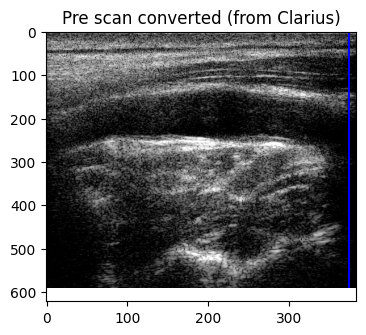

RF data
filename:  2025-05-04T16-12-12+0000_rf.raw
Loaded 40 raw frames of size, 104 x 1184 (lines x samples)
hdr:  {'id': 2, 'frames': 40, 'lines': 104, 'samples': 1184, 'samplesize': 2}
timestamps:  (40,)
rf_data:  (40, 1184, 104)


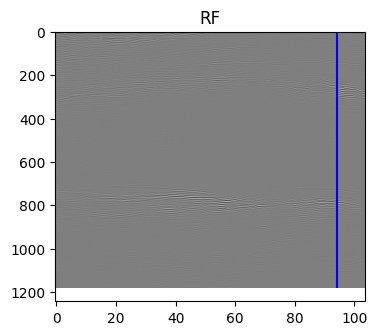

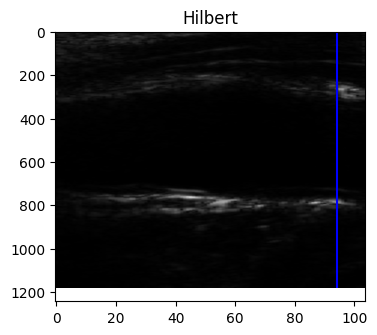

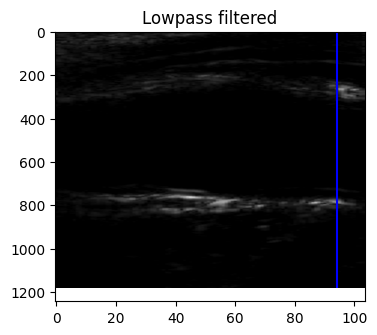

frame:  0.0 94.78762316827903
frame:  0 255


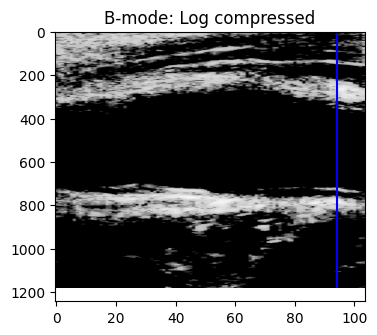

In [651]:
debug = True

line = None
for filename in files:
    # I-Q data
    if filename.endswith("iq.raw"):
        print("I-Q data")
        print("==========================================")
        hdr, timestamps, iq_data = rd.read_iq(filename.replace("rf.raw", "iq.raw"))
        iq_data = iq_data.transpose(2, 1, 0).astype('float')  # WxHxB -> BxHxW
        print("hdr: ", hdr)
        print("timestamps: ", timestamps.shape)
        print("iq_data: ", iq_data.shape, iq_data.min(), iq_data.max())
        frame = random.choice(iq_data)
        # Extract the I and Q channels
        idata = frame[0::2, :]
        qdata = frame[1::2, :]
        print("idata: ", idata.shape, idata.min(), idata.max())
        print("qdata: ", qdata.shape, qdata.min(), qdata.max())
        print(np.power(idata, 2).min(), np.power(idata, 2).max())
        print(np.power(qdata, 2).min(), np.power(qdata, 2).max())
        # Convert to B-mode
        frame = 10 * np.log10(1 + idata**2 + qdata**2)
        print("frame: ", frame.shape, frame.min(), frame.max())
        frame = (frame / frame.max() * 255).astype(np.uint8)
        print("frame rescale: ", frame.min(), frame.max())
        line = random.randint(0, frame.shape[1] - 1) if line is None else line
        plot_image(frame, line=line, title="I-Q data: Log compressed")

    # RF data
    if filename.endswith("rf.raw"):
        print("RF data")
        print("==========================================")
        print("filename: ", os.path.basename(filename))
        hdr, timestamps, rf_data = rd.read_rf(filename)
        rf_data = rf_data.transpose(2, 1, 0).astype('float')  # WxHxB -> BxHxW
        print("hdr: ", hdr)
        print("timestamps: ", timestamps.shape)
        print("rf_data: ", rf_data.shape)

        print("==========================================")

        # covnert RF to B
        bdata = np.zeros_like(rf_data, dtype='float')
        if line is None or line > rf_data.shape[2] - 1:
            line = random.randint(0, rf_data.shape[2] - 1)
        frame = random.choice(rf_data)
        # bdata[frame] = 20 * np.log10( np.abs(1 + hilbert(data[frame])))
        plot_image(frame, line=line, title="RF")
        frame = np.abs(hilbert(frame))
        plot_image(frame, line=line, title="Hilbert")
        frame = np.where(frame > 0.03 * np.max(frame), frame, 0)
        plot_image(frame, line=line, title="Lowpass filtered")
        frame = 20 * np.log10(np.abs(1 + frame))
        print("frame: ", frame.min(), frame.max())
        frame = (frame / frame.max() * 255).astype(np.uint8)
        print("frame: ", frame.min(), frame.max())
        plot_image(frame, line=line, title="B-mode: Log compressed")
        if debug:
            break

    # B-mode data
    if filename.endswith("env.raw"):
        print("B-mode data")
        print("==========================================")
        hdr, timestamps, bmode_data = rd.read_rf(filename.replace("rf.raw", "env.raw"))
        bmode_data = bmode_data.transpose(2, 1, 0)  # WxHxB -> BxHxW
        print("hdr: ", hdr)
        print("timestamps: ", timestamps.shape)
        print("bmode_data: ", bmode_data.shape, bmode_data.min(), bmode_data.max())
        if line is None or line > bmode_data.shape[2] - 1:
            line = random.randint(0, bmode_data.shape[2] - 1)
        plot_image(random.choice(bmode_data), line=line, title="Pre scan converted (from Clarius)")

# Reading doppler data

In [652]:
from scipy.signal import butter, filtfilt

def autocorrelation(data):
    """
        Data should be in format of BxHxWxT (T is the slow time axis)
        Data should be complex
        Compute the autocorrelation of the data using the formula:
        R(t) = sum(x(t+1) * conj(x(t))) for t = 0, 1, ..., T-2
        where x is the data and conj is the complex conjugate.
    """
    return np.sum(data[..., 1:] * np.conj(data[...,:-1]), axis=-1)

def compute_velocity(data, f0=7e6, prf=8e3, c=1540, theta_deg=45):
    """
        Compute the velocity from the autocorrelation map in cm/s
        Data should be in format of HxWxT (T is the slow time axis)
        Data should be complex
    """
    autocorr_map = autocorrelation(data)
    fd = np.imag(np.log(autocorr_map)) * prf / (2 * np.pi)
    velocity = fd * c / (2 * f0 * np.cos(np.deg2rad(theta_deg)))
    return velocity * 100  # convert to cm/s

def compute_power(iq_data):
    """
        Compute the power from the autocorrelation map
        Data should be in format of HxWxT (T is the slow time axis)
        Data should be complex
    """
    power = np.mean(np.abs(iq_data)**2, axis=-1)
    return 10 * np.log10(power / np.max(power))


def highpass_filter(data, cutoff, fs, order=3):
    b, a = butter(order, cutoff / (0.5 * fs), btype='high', analog=False)
    return filtfilt(b, a, data, axis=-1, padlen=3)

def apply_wall_filter(iq_data, cutoff=150, prf=8000):
    real_filtered = highpass_filter(iq_data.real, cutoff, prf)
    imag_filtered = highpass_filter(iq_data.imag, cutoff, prf)
    return real_filtered + 1j * imag_filtered


In [653]:
path = "/home/alvin/UltrAi/Datasets/raw_datasets/cartilage/raw_ultrasound_data/alvin/2025_05_04_all_imaging_modes/Vascular_carotid"
imaging_mode = "raw_3"
folder = glob(os.path.join(path, imaging_mode + "_*"))[0]
# folder = "/home/alvin/UltrAi/ai-pocus/clarius_raw/viewer/data/carotid/doppler"
print(os.path.basename(folder))
files = glob(f"{folder}/*.raw")
for file in files:
    print(os.path.basename(file))

raw_3_color_doppler
2025-05-04T16-15-54+0000_cfi.raw
2025-05-04T16-15-54+0000_env.raw
2025-05-04T16-15-54+0000_iq.raw


CFI data
Loaded 75 raw frames of size, 104 x 160 (lines x samples)
hdr:  {'id': 2, 'frames': 75, 'lines': 104, 'samples': 160, 'samplesize': 1}
timestamps:  (75,)
cfi_data:  (75, 160, 104) 32 228


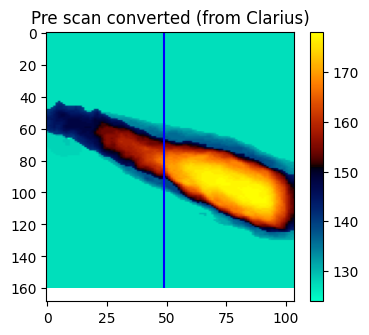

B-mode data
Loaded 79 raw frames of size, 384 x 592 (lines x samples)
hdr:  {'id': 1, 'frames': 79, 'lines': 384, 'samples': 592, 'samplesize': 1}
timestamps:  (79,)
bmode_data:  (79, 592, 384) 0 255


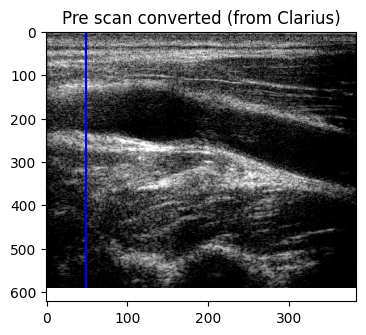

Doppler data
Loaded 79 raw frames of size, 1040 x 320 (lines x samples)
hdr:  {'id': 0, 'frames': 79, 'lines': 1040, 'samples': 160, 'samplesize': 4}
timestamps:  (79,)
iq_data:  (1040, 320, 79) -14899 15821
idata:  (1040, 160, 79) -14262 15821
qdata:  (1040, 160, 79) -14899 14153
doppler_iq_data:  (1040, 160, 79) (-14262-563j) (15821-1163j)
doppler_iq_data:  (104, 160, 10, 79) (-14262-563j) (15821-1163j)
doppler_iq_data:  (79, 160, 104, 10) (-14262-563j) (15821-1163j)
color_map:  (79, 160, 104) -44.67877092297278 44.67877092297278
frame:  (1184, 104) uint8


/tmp/ipykernel_3759932/293469983.py:20: RuntimeWarning: divide by zero encountered in log
  fd = np.imag(np.log(autocorr_map)) * prf / (2 * np.pi)


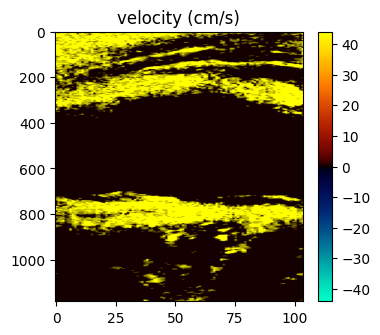

power_map:  (79, 160, 104) -82.34375 0.0
frame:  (160, 104) -78.36435 -13.506113


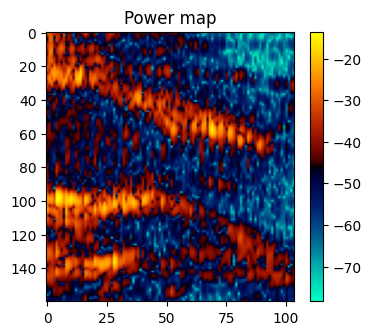

color_map:  (79, 160, 104) -44.67877092297278 44.67877092297278
frame:  (160, 104) -40.68478617739535 44.67877092297278


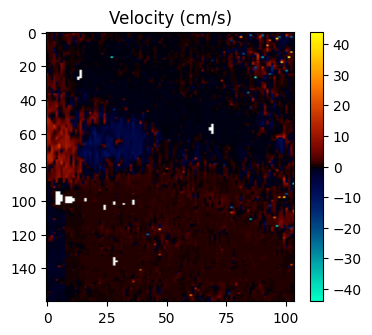

color_map:  (79, 160, 104) -44.67877092297278 44.67877092297278
frame:  (160, 104) -40.68478617739535 44.67877092297278


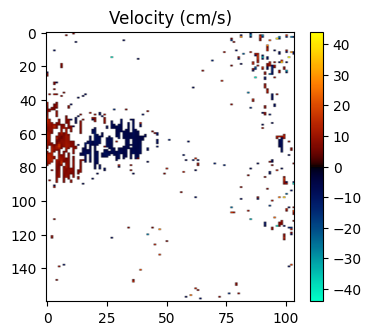

color_map:  (79, 160, 104) -40.77112282507094 39.91249621467842
frame:  (160, 104) 0.9152220812462599 9.125619015137314


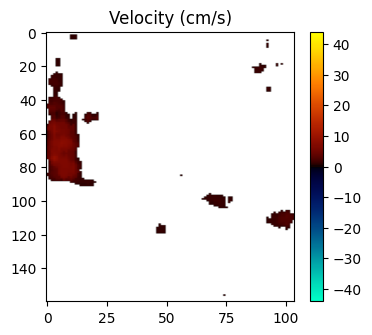

color_map:  (79, 160, 104) -40.67721762261319 39.15978947947643
frame:  (160, 104) 0.7940073993786375 7.9368391347227965


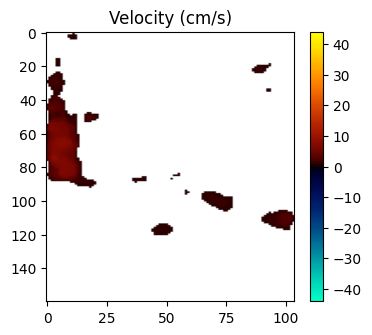

In [1242]:
import scipy.ndimage

# read yml file
import yaml
iq_yml = filename.replace(".raw", ".yml")
with open(iq_yml, 'r') as file:
    data = yaml.safe_load(file)

debug = True

ensemble = 10
theta_deg = int(data['lines'][0]['angle'].split(' ')[0])
prf = 8000
c = 1540
f0 = 7e6
nyquist_v = c * prf / (4 * f0) * 100 # cm/s
power_threshold = -20
line = None
for filename in files:
    # I-Q data
    if filename.endswith("iq.raw"):
        print("Doppler data")
        print("==========================================")
        hdr, timestamps, iq_data = rd.read_iq(filename)
        print("hdr: ", hdr)
        print("timestamps: ", timestamps.shape)
        print("iq_data: ", iq_data.shape, iq_data.min(), iq_data.max())

        # Extract the I and Q channels
        idata = iq_data[:,0::2]
        qdata = iq_data[:,1::2]
        print("idata: ", idata.shape, idata.min(), idata.max())
        print("qdata: ", qdata.shape, qdata.min(), qdata.max())

        doppler_iq_data = np.array(idata + 1j * qdata, dtype=np.complex64)
        print("doppler_iq_data: ", doppler_iq_data.shape, doppler_iq_data.min(), doppler_iq_data.max())

        doppler_iq_data = doppler_iq_data.reshape(doppler_iq_data.shape[0]//ensemble, doppler_iq_data.shape[1], ensemble, doppler_iq_data.shape[2])  # W*txHxB -> W*txHxB
        print("doppler_iq_data: ", doppler_iq_data.shape, doppler_iq_data.min(), doppler_iq_data.max())
        doppler_iq_data = doppler_iq_data.transpose(3, 1, 0, 2)  # W*txHxB -> BxHxWxt
        print("doppler_iq_data: ", doppler_iq_data.shape, doppler_iq_data.min(), doppler_iq_data.max())

        # Apply wall filter        
        mean = np.mean(doppler_iq_data, axis=-1, keepdims=True)
        doppler_iq_data = doppler_iq_data - mean        
        
        color_map = compute_velocity(doppler_iq_data, theta_deg=theta_deg)
        vmin = np.min(color_map)
        vmax = np.max(color_map)
        print("color_map: ", color_map.shape, color_map.min(), color_map.max())
        frame_id = random.randint(0, color_map.shape[0] - 1)
        color_frame = color_map[frame_id]
        print("frame: ", frame.shape, frame.dtype)
        # line = random.randint(0, frame.shape[1]) if line is None else line
        line = None
        plot_image(frame, line=line, title="velocity (cm/s)", cmap=rd.get_doppler_colormap(), cbar=True, vmin=-nyquist_v, vmax=nyquist_v)

        power_map = compute_power(doppler_iq_data)
        print("power_map: ", power_map.shape, power_map.min(), power_map.max())
        power_frame = power_map[frame_id]
        print("frame: ", power_frame.shape, power_frame.min(), power_frame.max())
        plot_image(power_frame, line=line, title="Power map", cmap=rd.get_doppler_colormap(), cbar=True)
        
        # filter the color map based on the power map
        color_map = np.ma.masked_where(power_map > power_threshold, color_map)
        print("color_map: ", color_map.shape, color_map.min(), color_map.max())
        color_frame = color_map[frame_id]
        print("frame: ", color_frame.shape, color_frame.min(), color_frame.max())
        plot_image(color_frame, line=line, title="Velocity (cm/s)", cmap=rd.get_doppler_colormap(), cbar=True, vmin=-nyquist_v, vmax=nyquist_v)

        # Filter out low velocity values
        color_map = np.ma.masked_where(np.abs(color_map) < 0.1 * np.max(color_map), color_map)
        print("color_map: ", color_map.shape, color_map.min(), color_map.max())
        color_frame = color_map[frame_id]
        print("frame: ", color_frame.shape, color_frame.min(), color_frame.max())
        plot_image(color_frame, line=line, title="Velocity (cm/s)", cmap=rd.get_doppler_colormap(), cbar=True, vmin=-nyquist_v, vmax=nyquist_v)

        # Apply median filter to the color map
        color_map = np.array([signal.medfilt2d(color_map, kernel_size=(7, 7)) for color_map in color_map])
        print("color_map: ", color_map.shape, color_map.min(), color_map.max())
        color_frame = color_map[frame_id]
        color_frame = np.ma.masked_where(color_frame < 0.1 * np.max(color_frame), color_frame, copy=False)
        print("frame: ", color_frame.shape, color_frame.min(), color_frame.max())
        plot_image(color_frame, line=line, title="Velocity (cm/s)", cmap=rd.get_doppler_colormap(), cbar=True, vmin=-nyquist_v, vmax=nyquist_v)
        
        # Apply median filter again to the color map
        color_map = np.array([signal.medfilt2d(color_map, kernel_size=(3, 3)) for color_map in color_map])
        print("color_map: ", color_map.shape, color_map.min(), color_map.max())
        color_frame = color_map[frame_id]
        color_frame = np.ma.masked_where(color_frame < 0.1 * np.max(color_frame), color_frame, copy=False)
        print("frame: ", color_frame.shape, color_frame.min(), color_frame.max())
        plot_image(color_frame, line=line, title="Velocity (cm/s)", cmap=rd.get_doppler_colormap(), cbar=True, vmin=-nyquist_v, vmax=nyquist_v)

        

        if debug:
            break

    # RF data
    if filename.endswith("rf.raw"):
        print("RF data")
        print("==========================================")
        print("filename: ", os.path.basename(filename))
        hdr, timestamps, rf_data = rd.read_rf(filename)
        rf_data = rf_data.transpose(2, 1, 0).astype('float')  # WxHxB -> BxHxW
        print("hdr: ", hdr)
        print("timestamps: ", timestamps.shape)
        print("rf_data: ", rf_data.shape)

        print("==========================================")

        # covnert RF to B
        bdata = np.zeros_like(rf_data, dtype='float')
        if line is None or line > rf_data.shape[2] - 1:
            line = random.randint(0, rf_data.shape[2] - 1)
        frame = random.choice(rf_data)
        # bdata[frame] = 20 * np.log10( np.abs(1 + hilbert(data[frame])))
        plot_image(frame, line=line, title="RF")
        frame = np.abs(hilbert(frame))
        plot_image(frame, line=line, title="Hilbert")
        frame = np.where(frame > 0.03 * np.max(frame), frame, 0)
        plot_image(frame, line=line, title="Lowpass filtered")
        frame = 20 * np.log10(np.abs(1 + frame))
        print("frame: ", frame.min(), frame.max())
        frame = (frame / frame.max() * 255).astype(np.uint8)
        print("frame: ", frame.min(), frame.max())
        plot_image(frame, line=line, title="B-mode: Log compressed")
        if debug:
            break

    # B-mode data
    if filename.endswith("env.raw"):
        print("B-mode data")
        print("==========================================")
        hdr, timestamps, bmode_data = rd.read_rf(filename.replace("rf.raw", "env.raw"))
        bmode_data = bmode_data.transpose(2, 1, 0)  # WxHxB -> BxHxW
        print("hdr: ", hdr)
        print("timestamps: ", timestamps.shape)
        print("bmode_data: ", bmode_data.shape, bmode_data.min(), bmode_data.max())
        if line is None or line > bmode_data.shape[2] - 1:
            line = random.randint(0, bmode_data.shape[2] - 1)
        plot_image(random.choice(bmode_data), line=line, title="Pre scan converted (from Clarius)")

    # CFI data
    if filename.endswith("cfi.raw"):
        print("CFI data")
        print("==========================================")
        hdr, timestamps, cfi_data = rd.read_rf(filename.replace("rf.raw", "env.raw"))
        cfi_data = cfi_data.transpose(2, 1, 0)  # WxHxB -> BxHxW
        print("hdr: ", hdr)
        print("timestamps: ", timestamps.shape)
        print("cfi_data: ", cfi_data.shape, cfi_data.min(), cfi_data.max())
        if line is None or line > cfi_data.shape[2] - 1:
            line = random.randint(0, cfi_data.shape[2] - 1)
        plot_image(random.choice(cfi_data), line=line, title="Pre scan converted (from Clarius)", cmap=rd.get_doppler_colormap(), cbar=True)

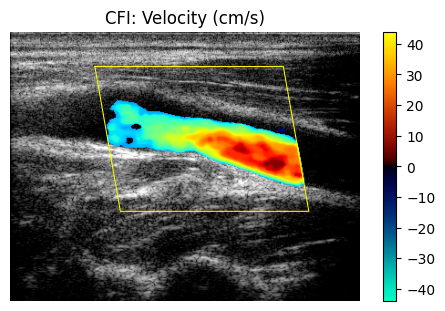

In [1458]:
   
rx_elements = [line['rx element'] for line in data['lines']]
min_rx = min(rx_elements)
max_rx = max(rx_elements)

sample_frame = random.randint(0, bmode_data.shape[0] - 1)
gray = bmode_data[sample_frame]
color = color_map[sample_frame]

# Down-sample the grayscale image
gray = cv2.resize(gray, (gray.shape[1], gray.shape[0] // 2), interpolation=cv2.INTER_LINEAR)

# Up-sample the color image
color = cv2.resize(color, (color.shape[1] * 2, color.shape[0]), interpolation=cv2.INTER_LINEAR)
orig_shape = color.shape

# Pad color image to match grayscale size
top = data['delay samples']
bottom = gray.shape[0] - (color.shape[0] + top)
left = (min_rx - 1) * 2
right = gray.shape[1] - (color.shape[1] + left)
color = np.pad(color, ((top, bottom), (left, right)), mode='constant', constant_values=0)

# Angle correct for the velocity image
shear_x = np.tan(np.radians(theta_deg))
M = np.float32([[1, shear_x, 0],
                [0, 1,       0]])
rows, cols = color.shape[:2]
color = cv2.warpAffine(color, M, (cols, rows), borderValue=0)

# Define ROI
top_left = (left, top)
top_right = (left + orig_shape[1] - 1, top)
bottom_right = (left + orig_shape[1] - 1, top + orig_shape[0] - 1)
bottom_left = (left, top + orig_shape[0] - 1)
corners = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)
# Apply shear transform on the corners
M = np.array([[1, shear_x], [0, 1]])
corners = np.dot(corners, M.T)
outline = np.vstack([corners, corners[0]])  # close polygon

# Normalize grayscale
gray_norm = (gray - gray.min()) / (gray.max() - gray.min())
gray_rgb = plt.cm.gray(gray_norm)[..., :3]

# Map color
color_mapped = plt.cm.jet((color - color.min()) / (color.max() - color.min()))[..., :3]

# Create mask and overlay
mask = np.abs(color) > 0.15 * np.max(color)
mask = np.expand_dims(mask, axis=-1)

# Final composite
composite = np.where(mask, color_mapped, gray_rgb)

# Original coordinates (after upsample & padding)
cfi_yml = iq_yml.replace("iq.yml", "cfi.yml")
with open(cfi_yml, 'r') as file:
    cfi_data = yaml.safe_load(file)



plt.figure(figsize=(6, 3.5))
plt.imshow(composite, cmap=rd.get_doppler_colormap(), vmin=-nyquist_v, vmax=nyquist_v)
# plt.plot([top_left[0], top_right[0], bottom_right[0], bottom_left[0], top_left[0]],
#             [top_left[1], top_right[1], bottom_right[1], bottom_left[1], top_left[1]],
#             color='yellow', linewidth=0.75)
plt.plot(outline[:, 0], outline[:, 1], color='yellow', linewidth=0.75)
plt.axis('off')
plt.title("CFI: Velocity (cm/s)", fontsize=12)
plt.colorbar()
plt.show()